In [ ]:
import pandas as pd
from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt

RANDOM_STATE = 1337

In [ ]:
ntest = 48744
ntrain = 307511

# используем предобработанные данные
united_norm_encoded = pd.read_csv('united_norm_encoded.csv')
y_train = pd.read_csv('y_train.csv')

# уберем id
sk_id_curr = united_norm_encoded['SK_ID_CURR']
sk_id_curr.to_csv('sk_id_curr.csv')
united_norm_encoded.drop(['SK_ID_CURR'], axis=1, inplace=True)

In [ ]:
x_train = united_norm_encoded[ntest:]
x_test = united_norm_encoded[:ntest]

# Logistic Regression



In [ ]:
# первый вариант -- 0,73052 на паблике
model = LogisticRegression(penalty='l1', solver='saga')
model.fit(x_train, y_train['TARGET'])
model.predict_proba(x_test)[:, 1]

In [ ]:
# второй вариант -- 0,66
clf = LogisticRegressionCV(cv=5, random_state=RANDOM_STATE, solver='saga', max_iter=200).fit(x_train, y_train)
subm_2 = clf.predict_proba(x_test)[:, 1]

In [ ]:
%%time
# преберем по сетке значения C
# третий вариант -- 0.73055
log_reg = LogisticRegression(random_state=RANDOM_STATE, solver='saga', penalty='l1')
grid_parameters = {
    'C': np.logspace(-10,1,20),
}
grid_log = GridSearchCV(
    estimator=log_reg,
    param_grid=grid_parameters,
    scoring=make_scorer(roc_auc_score),
    n_jobs=-1,
    cv=5,
    return_train_score=True
)
grid_log.fit(x_train, y_train['TARGET'])
subm_3 = grid_log.predict_proba(x_test)[:, 1]

CPU times: user 43.3 s, sys: 401 ms, total: 43.7 s
Wall time: 21min 15s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


# Decision tree


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

In [ ]:
def my_cross_validation_for_roc_auc(clf, X, y ,cv=5):
    X = np.array(X.copy())
    y = np.array(y.copy())
    kf = KFold(n_splits=cv)
    kf.get_n_splits(X)
    scores = []
    for train_index, test_index in kf.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf.fit(X_train, y_train)
        prediction_on_this_fold = clf.predict_proba(X_test)[:,1]
        
        score = roc_auc_score(y_score=prediction_on_this_fold, y_true=y_test)
        scores.append(score)
        
    return sum(scores)/len(scores)

## max_depth

In [ ]:
%%time
max_depths = [1, 3, 6, 8, 10]
depths_results = []
for depth in max_depths:
  model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth)
  depths_results.append(my_cross_validation_for_roc_auc(model, x_train, y_train))

CPU times: user 1min 23s, sys: 43.4 ms, total: 1min 23s
Wall time: 1min 23s


Максимальный скор на 8 деревьях

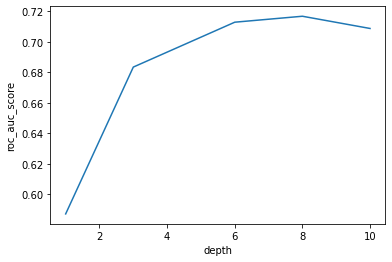

In [ ]:
plt.xlabel('depth')
plt.ylabel('roc_auc_score')
plt.plot(max_depths, depths_results);

## min_leaf

In [ ]:
%%time
min_leafs = [1, 2, 3, 4, 5]
leafs_results = []
for leaf in min_leafs:
  model = DecisionTreeClassifier(random_state=RANDOM_STATE, min_samples_leaf=leaf)
  leafs_results.append(my_cross_validation_for_roc_auc(model, x_train, y_train))

CPU times: user 4min 33s, sys: 58.1 ms, total: 4min 33s
Wall time: 4min 34s


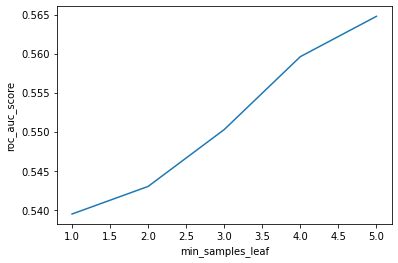

In [ ]:
plt.xlabel("min_samples_leaf")
plt.ylabel('roc_auc_score')
plt.plot(min_leafs, leafs_results)

## min_split

In [ ]:
%%time
min_split = [2, 4, 8, 16]
splits_results = []
for split in min_split:
  model = DecisionTreeClassifier(random_state=RANDOM_STATE, min_samples_split=split)
  splits_results.append(my_cross_validation_for_roc_auc(model, x_train, y_train))

CPU times: user 3min 57s, sys: 49.6 ms, total: 3min 57s
Wall time: 3min 58s


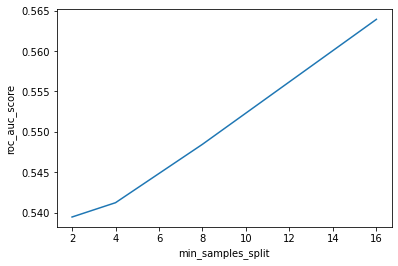

In [ ]:
plt.xlabel('min_samples_split')
plt.ylabel('roc_auc_score')
plt.plot(min_split, splits_results);

## GridSearchCV

In [ ]:
%%time
# 0.70753
tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
grid_parameters = {
    'min_samples_split': [2, 4, 10],
    'min_samples_leaf': [1, 5, 10],
    'max_depth': [4, 6, 8]
}
grid_tree = GridSearchCV(
    estimator=tree,
    param_grid=grid_parameters,
    scoring=make_scorer(roc_auc_score),
    n_jobs=-1,
    cv=5,
    return_train_score=True
)
grid_tree.fit(x_train, y_train['TARGET'])
subm_4 = grid_tree.predict_proba(x_test)[:, 1]

CPU times: user 6.01 s, sys: 246 ms, total: 6.25 s
Wall time: 5min 9s


Лучшие параметры:


{'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 10}

## RandomGridSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
%%time
# 0.70753
tree_random = DecisionTreeClassifier(random_state=RANDOM_STATE)
grid_parameters_random = {
    'min_samples_split': [2, 4, 10],
    'min_samples_leaf': [1, 5, 10],
    'max_depth': [4, 6, 8]
}
grid_tree_random = GridSearchCV(
    estimator=tree,
    param_grid=grid_parameters_random,
    scoring=make_scorer(roc_auc_score),
    n_jobs=-1,
    cv=5,
    return_train_score=True
)
grid_tree_random.fit(x_train, y_train['TARGET'])
subm_5 = grid_tree_random.predict_proba(x_test)[:, 1]

CPU times: user 5.97 s, sys: 214 ms, total: 6.18 s
Wall time: 5min 14s


Такой же скор и такие же лучшие параметры, как и при обычном GridSearchCV

# RandomForest


In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [62]:
%%time 
# больше не стал делать, т.к. долго обучается
n_trees = [1, 10, 25, 50]
n_trees_results = []
for n_tree in n_trees:
  model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=n_tree, n_jobs=-1)
  n_trees_results.append(my_cross_validation_for_roc_auc(model, x_train, np.ravel(y_train)))

CPU times: user 11min 3s, sys: 1.23 s, total: 11min 5s
Wall time: 5min 46s


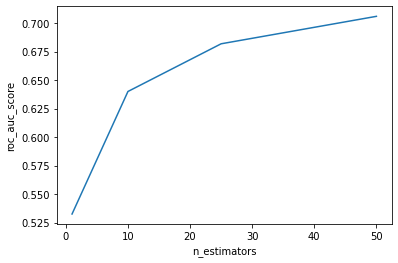

In [64]:
# чем больше деревьев, тем лучше
plt.xlabel('n_estimators')
plt.ylabel('roc_auc_score')
plt.plot(n_trees, n_trees_results);

In [66]:
max_depth_forest = [2, 5, 8]
max_depth_results = []
for depth in max_depth_forest:
  model = RandomForestClassifier(random_state=RANDOM_STATE, max_depth=depth)
  max_depth_results.append(my_cross_validation_for_roc_auc(model, x_train, np.ravel(y_train)))

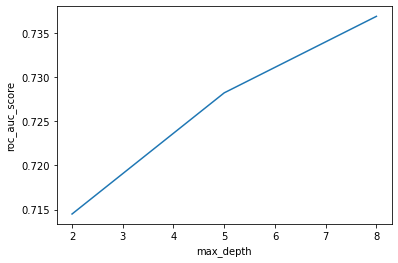

In [68]:
plt.xlabel('max_depth')
plt.ylabel('roc_auc_score')
plt.plot(max_depth_forest, max_depth_results);

In [72]:
%%time
# 0.65
forest = RandomForestClassifier(random_state=RANDOM_STATE)
grid_param_forest_random = {
    'n_estimators': [1, 10, 25, 50],
    'max_depth': [2, 8, 10]
}
grid_forest_random = GridSearchCV(
    estimator=forest,
    param_grid=grid_param_forest_random,
    scoring=make_scorer(roc_auc_score),
    n_jobs=-1,
    cv=5,
    return_train_score=True
)
grid_forest_random.fit(x_train, y_train['TARGET'])
subm_6 = grid_forest_random.predict_proba(x_test)[:, 1]

CPU times: user 1.57 s, sys: 311 ms, total: 1.88 s
Wall time: 6min 34s


Обучим случайный лес на лучших параметрах


In [76]:
# 0.71676
best_forest = RandomForestClassifier(random_state=RANDOM_STATE, max_depth=8, n_estimators=50, n_jobs=-1)
best_forest.fit(x_train, np.ravel(y_train))
best_forest_res = best_forest.predict_proba(x_test)[:, 1]

## Важность признаков

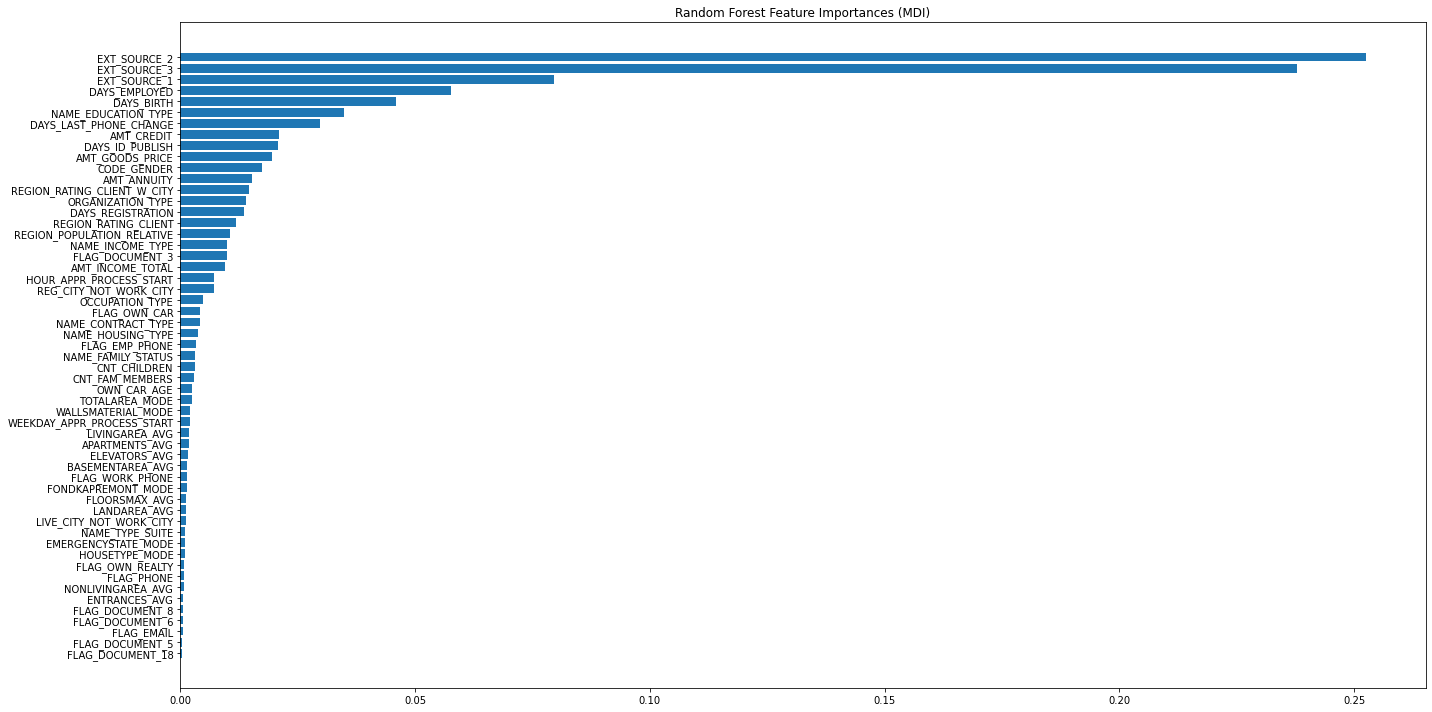

In [105]:
feature_names = np.r_[x_train.columns]
sorted_idx = best_forest.feature_importances_.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(20,10))
ax.barh(y_ticks, best_forest.feature_importances_[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

Обучим модель на 5 самых важных признаках

In [108]:
# 0.71768
best_forest.fit(x_train.loc[:, ['EXT_SOURCE_2', 'EXT_SOURCE_1', 'EXT_SOURCE_3', 'DAYS_EMPLOYED', 'DAYS_BIRTH']], np.ravel(y_train))
best_forest_res = best_forest.predict_proba(x_test.loc[:, ['EXT_SOURCE_2', 'EXT_SOURCE_1', 'EXT_SOURCE_3', 'DAYS_EMPLOYED', 'DAYS_BIRTH']])[:, 1]

Значение метрики чуть-чуть увеличилось

Обучим теперь на 4 признаках, исключая самый важный


In [110]:
# 0.69753
best_forest.fit(x_train.loc[:, ['EXT_SOURCE_1', 'EXT_SOURCE_3', 'DAYS_EMPLOYED', 'DAYS_BIRTH']], np.ravel(y_train))
best_forest_res = best_forest.predict_proba(x_test.loc[:, ['EXT_SOURCE_1', 'EXT_SOURCE_3', 'DAYS_EMPLOYED', 'DAYS_BIRTH']])[:, 1]

Скор упал, что логично

In [111]:
submission = pd.DataFrame()
submission['SK_ID_CURR'] = sk_id_curr[:ntest]
submission['TARGET'] = best_forest_res
submission.to_csv('submission_9.csv', index=False)